In [97]:
from keras.models import Model, load_model
from keras.layers import Input, Add
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import json

In [98]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

### Load data

In [99]:
prices_raw_df = pd.read_csv('EPEX_spot_DA_auction_hour_prices_20070720-20170831.csv')

In [100]:
prices_raw_df = prices_raw_df.set_index(prices_raw_df.columns[0]).rename({'DA_price':'price'}, axis=1)

In [101]:
prices_raw_df.index.name = 'time'

In [102]:
prices_raw_df.index = pd.to_datetime(prices_raw_df.index)

In [103]:
prices_raw_df.shape

(88704, 1)

In [104]:
prices_raw_df.head()

,price
time,
2007-07-20 00:00:00,25.69
2007-07-20 01:00:00,26.45
2007-07-20 02:00:00,24.33
2007-07-20 03:00:00,23.57
2007-07-20 04:00:00,18.96


### Check distribution

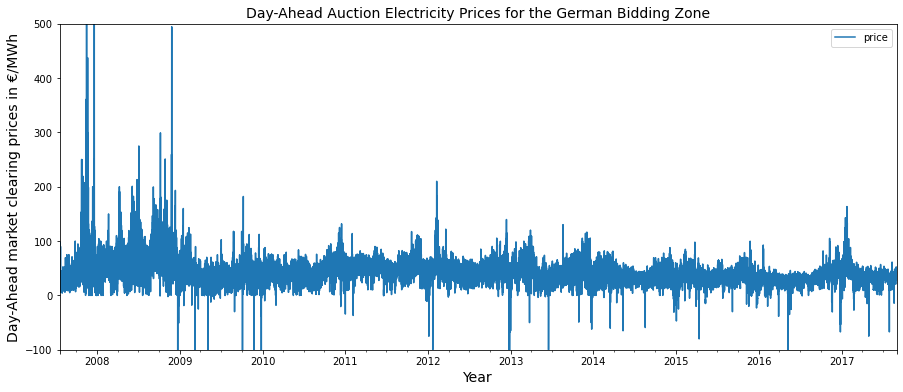

In [105]:
# plot the results
ax = prices_raw_df.plot(figsize=(15, 6))
ax.set_ylabel('Day-Ahead market clearing prices in €/MWh', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_title('Day-Ahead Auction Electricity Prices for the German Bidding Zone', fontsize=14)
ax.set_ylim((-100, 500));

In [106]:
def replace_outliers(data, column, tolerance):

    """Replace outliers out of 75% + tolerance * IQR or 25% - tolerance * IQR by these thresholds"""
    
    tol = tolerance
    data_prep = data.copy(deep=True)
    
    # calculate quantiles and inter-quantile range of the data
    q75 = data_prep[column].quantile(.75)
    q25 = data_prep[column].quantile(.25)
    IQR = q75 - q25

    # values larger (smaller) than q75 (q25) plus 'tol' times IQR get replaced by that value
    data_prep[column] = data_prep[column].apply(lambda x: q75 + tol * IQR if (x > q75 + tol * IQR) else x)
    data_prep[column] = data_prep[column].apply(lambda x: q25 - tol * IQR if (x < q75 - tol * IQR) else x)
    
    return data_prep

In [107]:
prices_df = replace_outliers(prices_raw_df, 'price', 3)


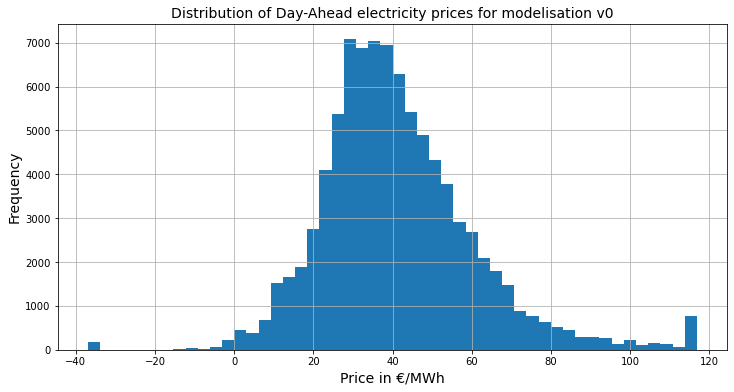

In [108]:
f, ax = plt.subplots(figsize=(12, 6))
prices_df.hist(bins=50, ax=ax)
ax.set_title('Distribution of Day-Ahead electricity prices for modelisation v0', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_xlabel('Price in €/MWh', fontsize=14);

In [109]:
prices_df.describe()

,price
count,88704.000000
mean,41.139642
std,19.455036
min,-36.910000
25%,29.000000
50%,38.640000
75%,50.970000
max,116.880000


### Scaling

In [110]:
scaler = MinMaxScaler()
prices_df['price'] = scaler.fit_transform(prices_df['price'].values.reshape(-1, 1))

### Lag creation

In [111]:
#7 days
lags = 168
for l in range(1, lags+1):
    prices_df['l_{}'.format(l)] = prices_df['price'].shift(l)

C:\Users\marti\AppData\Local\Temp\ipykernel_2852\203227825.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices_df['l_{}'.format(l)] = prices_df['price'].shift(l)
C:\Users\marti\AppData\Local\Temp\ipykernel_2852\203227825.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices_df['l_{}'.format(l)] = prices_df['price'].shift(l)
C:\Users\marti\AppData\Local\Temp\ipykernel_2852\203227825.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

C:\Users\marti\AppData\Local\Temp\ipykernel_2852\203227825.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices_df['l_{}'.format(l)] = prices_df['price'].shift(l)
C:\Users\marti\AppData\Local\Temp\ipykernel_2852\203227825.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices_df['l_{}'.format(l)] = prices_df['price'].shift(l)
C:\Users\marti\AppData\Local\Temp\ipykernel_2852\203227825.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

C:\Users\marti\AppData\Local\Temp\ipykernel_2852\203227825.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices_df['l_{}'.format(l)] = prices_df['price'].shift(l)
C:\Users\marti\AppData\Local\Temp\ipykernel_2852\203227825.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices_df['l_{}'.format(l)] = prices_df['price'].shift(l)
C:\Users\marti\AppData\Local\Temp\ipykernel_2852\203227825.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

In [112]:
prices_df = prices_df.dropna()

In [113]:
prices_df

,price,l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,...,l_159,l_160,l_161,l_162,l_163,l_164,l_165,l_166,l_167,l_168
time,,,,,,,,,,,,,,,,,,,,,
2007-07-27 00:00:00,0.388972,0.390402,0.435139,0.409454,0.421354,0.429027,0.435529,0.432083,0.454516,0.455231,...,0.591716,0.558164,0.468236,0.425450,0.406984,0.363288,0.393264,0.398205,0.411990,0.407049
2007-07-27 01:00:00,0.369920,0.388972,0.390402,0.435139,0.409454,0.421354,0.429027,0.435529,0.432083,0.454516,...,0.858053,0.591716,0.558164,0.468236,0.425450,0.406984,0.363288,0.393264,0.398205,0.411990
2007-07-27 02:00:00,0.343325,0.369920,0.388972,0.390402,0.435139,0.409454,0.421354,0.429027,0.435529,0.432083,...,0.880031,0.858053,0.591716,0.558164,0.468236,0.425450,0.406984,0.363288,0.393264,0.398205
2007-07-27 03:00:00,0.330451,0.343325,0.369920,0.388972,0.390402,0.435139,0.409454,0.421354,0.429027,0.435529,...,0.760518,0.880031,0.858053,0.591716,0.558164,0.468236,0.425450,0.406984,0.363288,0.393264
2007-07-27 04:00:00,0.300800,0.330451,0.343325,0.369920,0.388972,0.390402,0.435139,0.409454,0.421354,0.429027,...,0.578711,0.760518,0.880031,0.858053,0.591716,0.558164,0.468236,0.425450,0.406984,0.363288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31 19:00:00,0.524807,0.523506,0.513427,0.512712,0.512907,0.500488,0.512907,0.519475,0.531309,0.526627,...,0.434684,0.431888,0.435919,0.443592,0.457377,0.460823,0.495026,0.519019,0.529683,0.531894
2017-08-31 20:00:00,0.526692,0.524807,0.523506,0.513427,0.512712,0.512907,0.500488,0.512907,0.519475,0.531309,...,0.449899,0.434684,0.431888,0.435919,0.443592,0.457377,0.460823,0.495026,0.519019,0.529683
2017-08-31 21:00:00,0.512582,0.526692,0.524807,0.523506,0.513427,0.512712,0.512907,0.500488,0.512907,0.519475,...,0.487418,0.449899,0.434684,0.431888,0.435919,0.443592,0.457377,0.460823,0.495026,0.519019


In [114]:
prices_df.index.hour

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
           dtype='int64', name='time', length=88536)

In [115]:
# create feature and label dataframes
prelim_features = prices_df.drop('price', axis=1)
prelim_labels = pd.DataFrame(prices_df['price'])

In [116]:
# format labels to 24 hour output range
for i in range(0, 24):
    prelim_labels['t_{}'.format(i)] = prelim_labels['price'].shift(-i)
prelim_labels.drop('price', axis=1, inplace=True)

In [117]:
# apply one-day discretization to the data
labels = prelim_labels[prelim_labels.index.hour == 0]
features = prelim_features[prelim_features.index.hour == 0]

In [118]:
features_train = features[:'2016']
features_test = features['2017':]
labels_train = labels[:'2016']

samples_train = len(features_train)
samples_test = len(features_test)
timesteps = 168

In [119]:
# np ndarrays
features_train = features_train.to_numpy().reshape(samples_train, timesteps, 1)
features_test = features_test.to_numpy().reshape(samples_test, timesteps, 1)
labels_train = labels_train.to_numpy()

features_train.shape, labels_train.shape

((3446, 168, 1), (3446, 24))

### Naive modelisation

In [120]:
test_raw = prices_raw_df['2017']

C:\Users\marti\AppData\Local\Temp\ipykernel_2852\1740568523.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test_raw = prices_raw_df['2017']


In [121]:
# calculate benchmarks for test set and save them to dataframe
benchmark_results = pd.DataFrame(index=test_raw.index)

benchmark_results['last_23h'] = prices_raw_df.shift(23)
benchmark_results['last_day'] = prices_raw_df.shift(24)
benchmark_results['previous_7_days'] = prices_raw_df.shift(24*7)
benchmark_results['last_5_days_average'] = pd.concat([prices_raw_df.shift(24 * w) for w in range(1, 5)], axis=1).mean(axis=1)

In [122]:
benchmark_results = benchmark_results.dropna()

In [123]:
true = test_raw[test_raw.index.isin(benchmark_results.index)]

In [124]:
benchmark_results.shape, true.shape

((5832, 4), (5832, 1))

In [125]:
for col in benchmark_results.columns:
    #pred = benchmark_results[col].as_matrix()
    print('MAE of {} benchmark model: '.format(col), mean_absolute_error(y_pred=benchmark_results[col], y_true=true))

MAE of last_23h benchmark model:  8.994425582990399
MAE of last_day benchmark model:  8.525744170096022
MAE of previous_7_days benchmark model:  9.138191015089163
MAE of last_5_days_average benchmark model:  9.175044581618655


### LSTM

In [126]:
X_train, X_valid, y_train, y_valid = train_test_split(features_train, labels_train, test_size=0.1, random_state=7)

In [127]:
X_train.shape

(3101, 168, 1)

In [128]:
def train_predict_evaluate(model, X_train, X_valid, y_train, y_valid, 
                           batch_size, epochs, verbose=0):
    
    """Fit model to training data. Use best performant on validation data to predict for the test set. 
    Evaluate on the test set and return results as dataframes"""
    
    # train model, save best keep best performer on validation set
    #checkpoint = ModelCheckpoint('./models/' + filename, save_best_only=True)
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                     verbose=verbose, batch_size=batch_size, epochs=epochs)
    
    # load best model
    #best = load_model('./models/' + filename)
    
    return model

In [129]:
print(np.any(np.isnan(X_train)))
print(np.any(np.isnan(y_train)))

False
False


In [130]:
X_train.shape

(3101, 168, 1)

In [131]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Conv1D(64, kernel_size=24, strides=24, padding='valid')(input_layer)
x = LSTM(32, recurrent_activation='relu')(x)
output_layer = Dense(24)(x)
model = Model(inputs=[input_layer], outputs=[output_layer])

model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 168, 1)]          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 64)             1600      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 24)                792       
Total params: 14,808
Trainable params: 14,808
Non-trainable params: 0
_________________________________________________________________


In [138]:
# train the model and calculate the performance on the test set
model = train_predict_evaluate(model, X_train, X_valid, y_train, y_valid, 50, 100, 
                                       verbose=1)

Epoch 1/100
63/63 [==============================] - 2s 9ms/step - loss: 0.1059 - val_loss: 0.0091
Epoch 2/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 3/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0066 - val_loss: 0.0071
Epoch 4/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 5/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 6/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0065
Epoch 7/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0067
Epoch 8/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0078
Epoch 9/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0074
Epoch 10/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 11/

63/63 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 84/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0044
Epoch 85/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 86/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 87/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 88/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 89/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 90/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 91/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 92/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 93/100


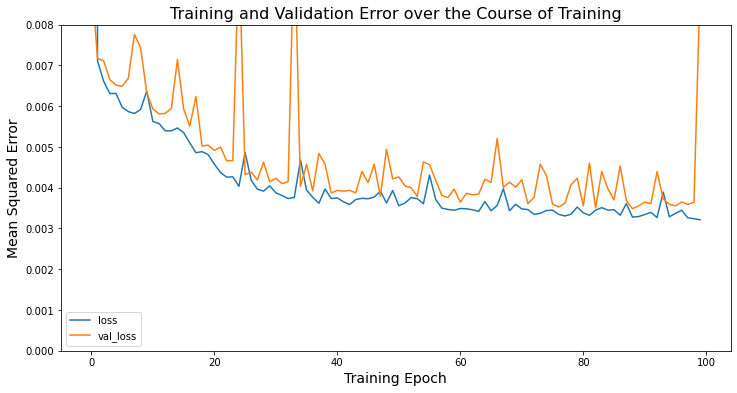

In [139]:
f, ax = plt.subplots()
pd.DataFrame(model.history.history).plot(figsize=(12, 6), ax=ax)
ax.set_ylim([0, 0.008])
ax.set_title('Training and Validation Error over the Course of Training', fontsize=16)
ax.set_ylabel('Mean Squared Error', fontsize=14)
ax.set_xlabel('Training Epoch', fontsize=14);

### Save

In [158]:
model.save('lstm_poc_v0')

INFO:tensorflow:Assets written to: lstm_poc_v0\assets


### Prediction

In [140]:
# predict for test set
pred = model.predict(features_test)

In [141]:
features_test.shape

(243, 168, 1)

In [142]:
labels_test = labels['2017':]

In [143]:
# transform back to original data scale
pred = scaler.inverse_transform(pred.flatten().reshape(-1, 1))
y_test = scaler.inverse_transform(labels_test.to_numpy().flatten().reshape(-1,1))

In [144]:
pred.shape, test_raw.shape

((5832, 1), (5832, 1))

In [145]:
test_raw.to_numpy().flatten()

array([20.96, 20.9 , 18.13, ..., 41.92, 35.59, 33.41])

In [146]:
results = pd.DataFrame({'prediction':pred.flatten(), 'true values':test_raw.to_numpy().flatten()})

In [147]:
results

,prediction,true values
0,16.688089,20.96
1,14.408577,20.90
2,7.825580,18.13
3,6.241239,16.03
4,2.688673,16.43
...,...,...
5827,33.987194,43.80
5828,37.199081,44.09
5829,32.902214,41.92
5830,32.667473,35.59


In [148]:
print('MAE: ', mean_absolute_error(y_pred=results['prediction'], y_true=results['true values']))

MAE:  10.18965313720099


In [149]:
len(labels_test.index.month)

243

In [150]:
np.repeat(labels_test.index, 24)

DatetimeIndex(['2017-01-01', '2017-01-01', '2017-01-01', '2017-01-01',
               '2017-01-01', '2017-01-01', '2017-01-01', '2017-01-01',
               '2017-01-01', '2017-01-01',
               ...
               '2017-08-31', '2017-08-31', '2017-08-31', '2017-08-31',
               '2017-08-31', '2017-08-31', '2017-08-31', '2017-08-31',
               '2017-08-31', '2017-08-31'],
              dtype='datetime64[ns]', name='time', length=5832, freq=None)

Text(0.5, 1.0, 'Long Term Predictive Performance')

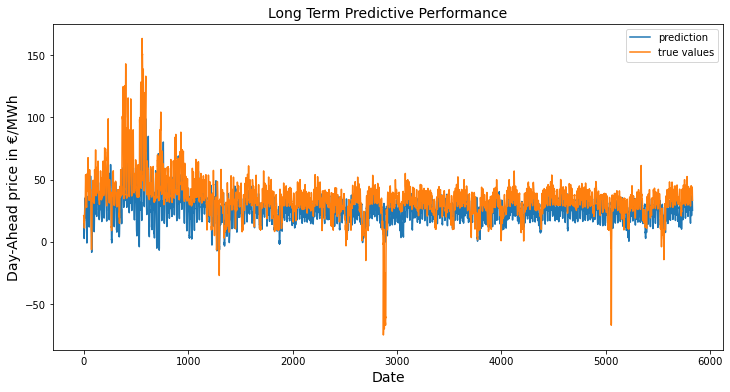

In [151]:
f, ax = plt.subplots(figsize=(12, 6))
results.plot(ax=ax)
ax.set_ylabel('Day-Ahead price in €/MWh', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('Long Term Predictive Performance', fontsize=14)

In [156]:
n_random = np.random.randint(0, len(results))

Text(0.5, 1.0, 'Long Term predictive Performance - Extract')

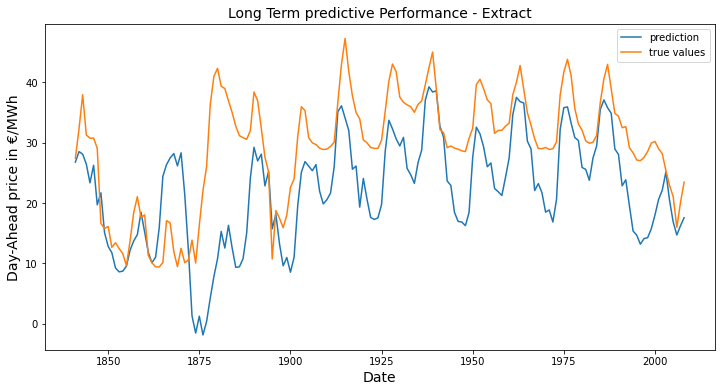

In [157]:
f, ax = plt.subplots(figsize=(12, 6))
n_window = 168
results[n_random:n_random+n_window].plot(ax=ax);
ax.set_ylabel('Day-Ahead price in €/MWh', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('Long Term predictive Performance - Extract', fontsize=14)

### Comparaison with ARIMA

* Compare march

In [81]:
# split a univariate sequence
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
 
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)